# Lab: Neural networks

In this lab we will build dense neural networks on the MNIST dataset.

Make sure you read the tutorial for this lab first.

## Load the data and create train-test splits

In [1]:
# Auto-setup when running on Google Colab
if 'google.colab' in str(get_ipython()):
    !pip install openml
    !pip install pytorch_lightning

# General imports
%matplotlib inline
import numpy as np
import pandas as pd
import openml as oml
import random
import matplotlib.pyplot as plt
import pytorch_lightning as pl
import torch
import torch.nn.functional as F
from torch import nn
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from torchsummary import summary
from sklearn.metrics import classification_report

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.4/160.4 kB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.1/95.1 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 68.5 MB/s eta 0:00:00
  Created wheel for liac-arff: filename=liac_arff-2.5.0-py3-none-any.whl size=11717 sha256=805259b35fbc24ed63c92a65991cb0756de906f927c1510b1a6100dadb85d01d
  Stored in directory: /root/.cache/pip/wheels/00/23/31/5e562fce1f95aabe57f2a7320d07433ba1cd152bcde2f6a002
Successfully built liac-arff
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.1/823.1 kB 35.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 113.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 95.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 56.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━

<ipython-input-2-cd5f478f5b18>:3: FutureWarning: Support for `dataset_format='array'` will be removed in 0.15,start using `dataset_format='dataframe' to ensure your code will continue to work. You can use the dataframe's `to_numpy` function to continue using numpy arrays.
  X, y, _, _ = mnist.get_data(target=mnist.default_target_attribute, dataset_format='array');


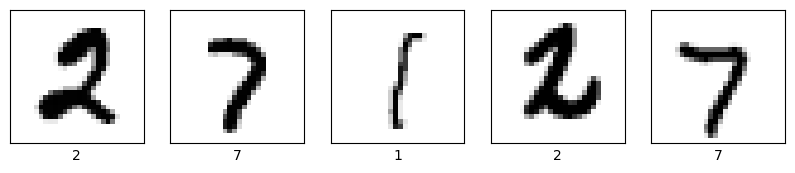

In [2]:
# Download MNIST data. Takes a while the first time.
mnist = oml.datasets.get_dataset(554)
X, y, _, _ = mnist.get_data(target=mnist.default_target_attribute, dataset_format='array');
X = X.reshape(70000, 28, 28)

# Take some random examples
from random import randint
fig, axes = plt.subplots(1, 5,  figsize=(10, 5))
for i in range(5):
    n = randint(0,70000)
    axes[i].imshow(X[n], cmap=plt.cm.gray_r)
    axes[i].set_xticks([])
    axes[i].set_yticks([])
    axes[i].set_xlabel("{}".format(y[n]))
plt.show();

In [3]:
# For MNIST, there exists a predefined stratified train-test split of 60000-10000. We therefore don't shuffle or stratify here.
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=60000, random_state=0)

## Exercise 1: Preprocessing
* Normalize the data: map each feature value from its current representation (an integer between 0 and 255) to a floating-point value between 0 and 1.0.
* Create a train-test split using the first 60000 examples for training
* (Optional) Flatten the data
* (Optional) Convert the data (numpy arrays) to PyTorch tensors
* Create a TensorDataset for the training data, and another for the testing data

In [4]:
# Normalize the data
X_train = X_train / 255.0
X_test = X_test / 255.0

In [5]:
# Flatten the data
X_train = X_train.reshape(-1, 28*28).astype(np.float32)
X_test = X_test.reshape(-1, 28*28).astype(np.float32)

In [6]:
y_train = y_train.astype(np.int64)
y_test = y_test.astype(np.int64)

print("Input shape:", X_train[0].shape)
print("Output shape:", y_train[0].shape)

Input shape: (784,)
Output shape: ()


In [7]:
# Convert the data to PyTorch tensors
X_train_tensor = torch.tensor(X_train)
y_train_tensor = torch.tensor(y_train)
X_test_tensor = torch.tensor(X_test)
y_test_tensor = torch.tensor(y_test)

In [8]:
# Create a TensorDataset
train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = torch.utils.data.TensorDataset(X_test_tensor, y_test_tensor)

## Exercise 2: Create a deep neural net model

Implement a `create_model` function which defines the topography of the deep neural net, specifying the following:

* The number of layers in the deep neural net: Use 2 dense layers for now (one hidden en one output layer)
* The number of nodes in each layer: these are parameters of your function.
* Any regularization layers. Add at least one dropout layer.

Consider:
* What should be the shape of the input layer?
* Which activation function you will need for the last layer, since this is a 10-class classification problem?

In [9]:
### Create and compile a 'deep' neural net
class Neural_Networks_1(nn.Module):
    def __init__(self, layer_1_units=32, layer_2_units=10, dropout_rate=0.3):
        super(Neural_Networks_1, self).__init__()
        self.fc1 = nn.Linear(28*28, layer_1_units)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(layer_1_units, layer_2_units)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

def create_model(layer_1_units=32, layer_2_units=10, dropout_rate=0.3):
    return Neural_Networks_1(layer_1_units, layer_2_units, dropout_rate)

## Exercise 3: Create a training function
Implement a `train_model` function which trains and evaluates a given model.
It should print out the train and validation loss and accuracy.

In [10]:
def train_model(model, train_dataset, val_dataset, epochs=10, batch_size=64, learning_rate=0.001):
    """
    model: the model to train
    train_dataset: the training data and labels
    test_dataset: the test data and labels
    epochs: the number of epochs to train for
    batch_size: the batch size for minibatch SGD
    learning_rate: the learning rate for the optimizer
    """

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()

    history = {'accuracy': [], 'val_accuracy': [], 'loss': [], 'val_loss': []}

    for epoch in range(epochs):
        # Training phase
        model.train()
        running_loss = 0
        correct = 0
        total = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += y_batch.size(0)
            correct += predicted.eq(y_batch).sum().item()

        train_loss = running_loss / len(train_loader)
        train_accuracy = correct / total

        # Validation phase
        model.eval()
        val_loss = 0
        correct = 0
        total = 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)

                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)

                val_loss += loss.item()
                _, predicted = outputs.max(1)
                total += y_batch.size(0)
                correct += predicted.eq(y_batch).sum().item()

        val_loss = val_loss / len(val_loader)
        val_accuracy = correct / total

        # Store history
        history['loss'].append(train_loss)
        history['accuracy'].append(train_accuracy)
        history['val_loss'].append(val_loss)
        history['val_accuracy'].append(val_accuracy)

        print(f"Epoch {epoch+1}/{epochs}: Train Loss={train_loss:.4f}, Train Acc={train_accuracy:.4f}, Val Loss={val_loss:.4f}, Val Acc={val_accuracy:.4f}")

    return history

## Exercise 4: Evaluate the model

Train the model with a learning rate of 0.003, 50 epochs, batch size 4000, and a validation set that is 20% of the total training data.

Use default settings otherwise. Plot the learning curve of the loss, validation loss, accuracy, and validation accuracy. Finally, report the performance on the test set.

Try to run the model on GPU.

Feel free to use the plotting function below, or implement the callback from the tutorial to see results in real time.

In [11]:
# Prepare phrase
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_subset, val_subset = random_split(train_dataset, [train_size, val_size])

In [12]:
# Create the model
model = create_model().to('cuda')
summary(model, (1,784))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                [-1, 1, 32]          25,120
           Dropout-2                [-1, 1, 32]               0
            Linear-3                [-1, 1, 10]             330
Total params: 25,450
Trainable params: 25,450
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.10
Estimated Total Size (MB): 0.10
----------------------------------------------------------------


In [13]:
# Training phrase
history = train_model(model, train_subset, val_subset, epochs=50, batch_size=4000, learning_rate=0.003)

Epoch 1/50: Train Loss=1.7861, Train Acc=0.4991, Val Loss=1.1786, Val Acc=0.7827
Epoch 2/50: Train Loss=1.0150, Train Acc=0.7251, Val Loss=0.6478, Val Acc=0.8494
Epoch 3/50: Train Loss=0.7107, Train Acc=0.7919, Val Loss=0.4909, Val Acc=0.8734
Epoch 4/50: Train Loss=0.5863, Train Acc=0.8270, Val Loss=0.4177, Val Acc=0.8862
Epoch 5/50: Train Loss=0.5214, Train Acc=0.8462, Val Loss=0.3763, Val Acc=0.8972
Epoch 6/50: Train Loss=0.4829, Train Acc=0.8597, Val Loss=0.3470, Val Acc=0.9032
Epoch 7/50: Train Loss=0.4466, Train Acc=0.8700, Val Loss=0.3244, Val Acc=0.9077
Epoch 8/50: Train Loss=0.4275, Train Acc=0.8775, Val Loss=0.3085, Val Acc=0.9121
Epoch 9/50: Train Loss=0.4097, Train Acc=0.8808, Val Loss=0.2944, Val Acc=0.9167
Epoch 10/50: Train Loss=0.3930, Train Acc=0.8856, Val Loss=0.2815, Val Acc=0.9197
Epoch 11/50: Train Loss=0.3802, Train Acc=0.8898, Val Loss=0.2720, Val Acc=0.9228
Epoch 12/50: Train Loss=0.3675, Train Acc=0.8956, Val Loss=0.2625, Val Acc=0.9239
Epoch 13/50: Train Loss=0

In [14]:
# Helper plotting function
#
# history: the history object returned by the training function

def plot_curve(history):
    """
    Plots the learning curves for accuracy and loss.

    history: Dictionary containing 'accuracy', 'val_accuracy', 'loss', 'val_loss' per epoch.
    """
    epochs = range(1, len(history["accuracy"]) + 1)

    plt.figure(figsize=(12, 5))

    # Accuracy Plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history["accuracy"], label="Train Accuracy")
    plt.plot(epochs, history["val_accuracy"], label="Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Accuracy Curve")
    plt.legend()

    # Loss Plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history["loss"], label="Train Loss")
    plt.plot(epochs, history["val_loss"], label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Loss Curve")
    plt.legend()

    plt.show()

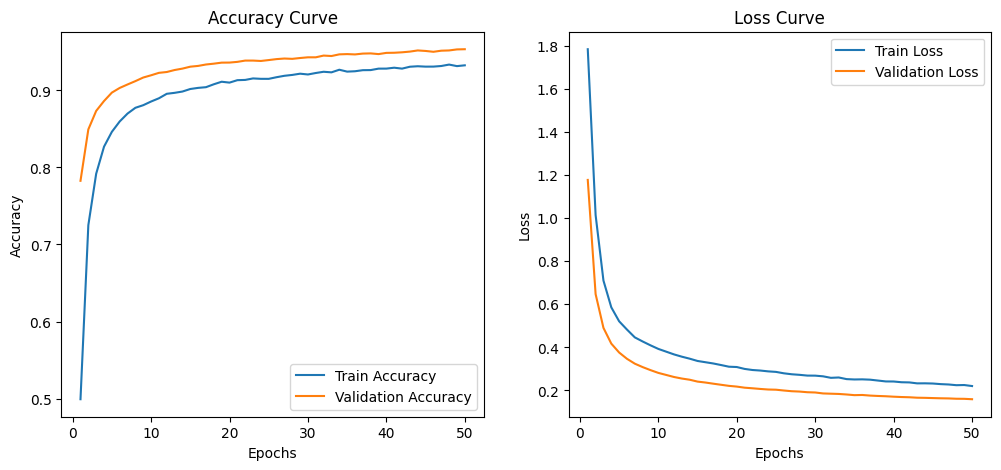

In [15]:
# Plot learning curve
plot_curve(history)

In [16]:
# performance on the test set
def evaluate(model, test_dataset, batch_size=64):
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    model.eval()

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            preds = torch.argmax(outputs, dim=1)
            all_preds.append(preds.cpu())
            all_labels.append(labels.cpu())

    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)

    # Print classification report
    print(classification_report(all_labels, all_preds, digits=4))

evaluate(model, test_dataset)

              precision    recall  f1-score   support

           0     0.9780    0.9809    0.9794       996
           1     0.9773    0.9790    0.9781      1141
           2     0.9445    0.9490    0.9468      1040
           3     0.9334    0.9269    0.9302      1013
           4     0.9347    0.9522    0.9434       962
           5     0.9330    0.9363    0.9346       863
           6     0.9629    0.9697    0.9662       989
           7     0.9605    0.9605    0.9605      1064
           8     0.9538    0.9211    0.9371       963
           9     0.9289    0.9309    0.9299       969

    accuracy                         0.9514     10000
   macro avg     0.9507    0.9506    0.9506     10000
weighted avg     0.9514    0.9514    0.9514     10000



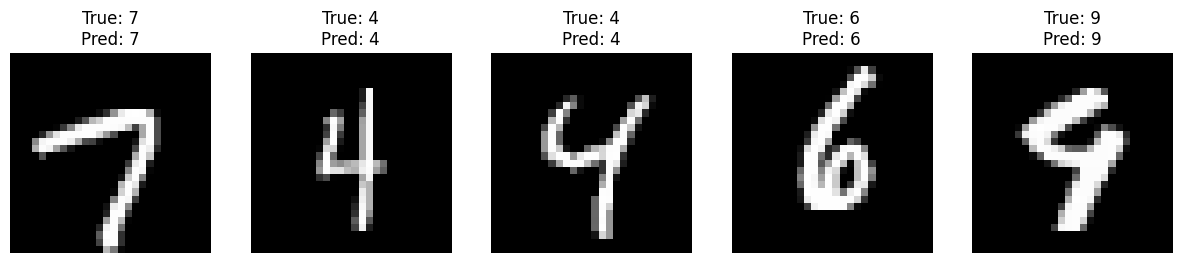

In [17]:
def predict_random_images(model, test_dataset):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    model.eval()

    idx = random.sample(range(len(test_dataset)), 5)
    images = []
    labels = []
    for i in idx:
        img, label = test_dataset[i]
        images.append(img)
        labels.append(label)

    images_tensor = torch.stack(images).to(device)

    with torch.no_grad():
        outputs = model(images_tensor)
        preds = torch.argmax(outputs, dim=1)

    fig, axes = plt.subplots(1, 5, figsize=(15, 5))
    for i in range(5):
        img = images[i].squeeze().cpu().numpy()
        axes[i].imshow(img.reshape(28,28), cmap="gray")
        axes[i].set_title(f"True: {labels[i]}\nPred: {preds[i].item()}")
        axes[i].axis('off')
    plt.show()
predict_random_images(model, test_dataset)

## Exercise 5: Optimize the model

Try to optimize the model, either manually or with a tuning method. At least optimize the following:
* the number of hidden layers
* the number of nodes in each layer
* the amount of dropout layers and the dropout rate

Try to reach at least 96% accuracy against the test set.

In [18]:
class Neural_Networks_2(nn.Module):
    def __init__(self, layer_1_units=256, layer_2_units=128, layer_3_units=64, dropout_rate=0.4):
        super(Neural_Networks_2, self).__init__()
        self.fc1 = nn.Linear(28*28, layer_1_units)
        self.fc2 = nn.Linear(layer_1_units, layer_2_units)
        self.fc3 = nn.Linear(layer_2_units, layer_3_units)
        self.fc4 = nn.Linear(layer_3_units, 10)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        x = self.dropout(x)
        x = self.fc4(x)
        return x

def create_model_2(layer_1_units=256, layer_2_units=128, layer_3_units=64, dropout_rate=0.4):
    return Neural_Networks_2(layer_1_units, layer_2_units, layer_3_units, dropout_rate)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 256]         200,960
           Dropout-2               [-1, 1, 256]               0
            Linear-3               [-1, 1, 128]          32,896
           Dropout-4               [-1, 1, 128]               0
            Linear-5                [-1, 1, 64]           8,256
           Dropout-6                [-1, 1, 64]               0
            Linear-7                [-1, 1, 10]             650
Total params: 242,762
Trainable params: 242,762
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.93
Estimated Total Size (MB): 0.94
----------------------------------------------------------------
Epoch 1/50: Train Loss=1.7439, Train Acc=0.4142, Val Loss=0.6618, Val Acc=0.8009
Epoch 2/50: Train Loss=0.

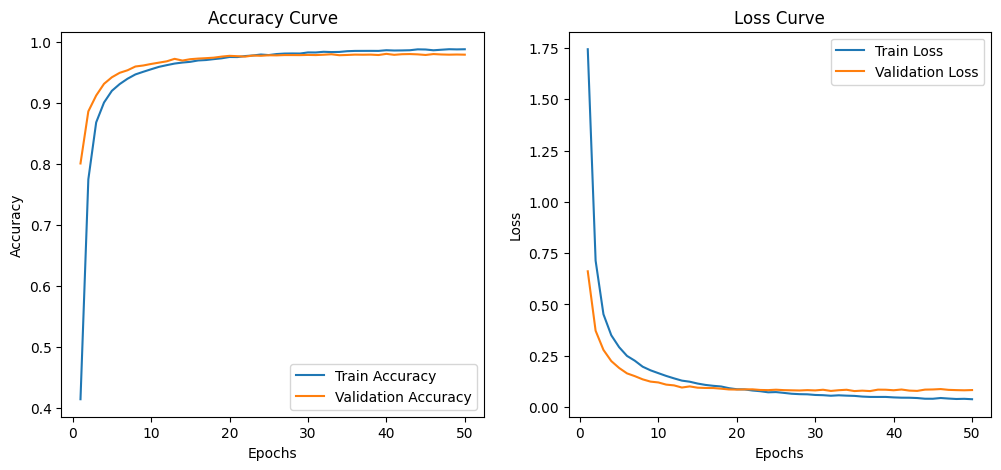

              precision    recall  f1-score   support

           0     0.9939    0.9880    0.9909       996
           1     0.9844    0.9939    0.9891      1141
           2     0.9659    0.9798    0.9728      1040
           3     0.9750    0.9625    0.9687      1013
           4     0.9783    0.9834    0.9808       962
           5     0.9711    0.9745    0.9728       863
           6     0.9849    0.9879    0.9864       989
           7     0.9821    0.9784    0.9802      1064
           8     0.9615    0.9595    0.9605       963
           9     0.9718    0.9598    0.9657       969

    accuracy                         0.9771     10000
   macro avg     0.9769    0.9767    0.9768     10000
weighted avg     0.9771    0.9771    0.9771     10000



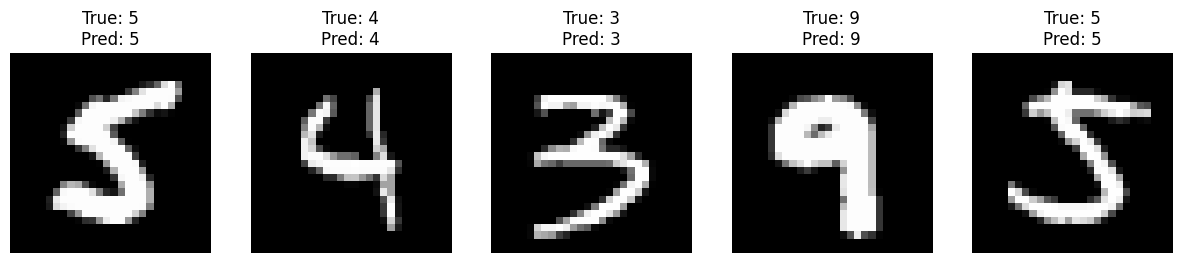

In [19]:
model_2 = create_model_2(layer_1_units=256, layer_2_units=128, layer_3_units=64, dropout_rate=0.4).to('cuda')
summary(model_2, (1,784))
history_2 = train_model(model_2, train_subset, val_subset, epochs=50, batch_size=4000, learning_rate=0.003)
plot_curve(history_2)
evaluate(model_2, test_dataset)
predict_random_images(model_2, test_dataset)

In [21]:
torch.save(model_2.state_dict(), 'model_weights.pth')

## Exercise 6: Optimize the model / Blind test

+ Hình thức: 18h cùng ngày, Trainer cung cấp tập blind test -> Trainee thực hiện test trong vòng 30 phút -> 18h30 đóng cổng submit kết quả lên driver.
+ Metrics: Precision, Recall, and F1-Score (per class and averaged)


In [33]:
blind_test_model = create_model_2(layer_1_units=256, layer_2_units=128, layer_3_units=64, dropout_rate=0.4).to('cuda')
blind_test_model.load_state_dict(torch.load('model_weights.pth'))
blind_test_model.eval()

Neural_Networks_2(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=10, bias=True)
  (dropout): Dropout(p=0.4, inplace=False)
)

In [34]:
# what inside the blindtest set?
blind_set = np.load('/content/mnist_test_data.npz')
print(blind_set.files)
print(blind_set['x_test'].shape)

['x_test', 'y_test']
(10000, 28, 28)


In [35]:
def load_blind_test_data(file_path):
    data = np.load(file_path)
    if isinstance(data, np.lib.npyio.NpzFile):
        X_test = data['x_test']
    else:
        X_test = data

    X_test = X_test.astype(np.float32) / 255.0
    X_test = X_test.reshape(-1, 28*28)
    X_test_tensor = torch.tensor(X_test)

    Y_test = data['y_test']
    Y_test_tensor = torch.tensor(Y_test)

    test_dataset = torch.utils.data.TensorDataset(X_test_tensor, Y_test_tensor)
    return test_dataset

blind_test_dataset = load_blind_test_data('/content/mnist_test_data.npz')

              precision    recall  f1-score   support

           0     0.9969    0.9959    0.9964       980
           1     0.9947    0.9965    0.9956      1135
           2     0.9904    0.9952    0.9928      1032
           3     0.9901    0.9950    0.9926      1010
           4     0.9919    0.9969    0.9944       982
           5     0.9888    0.9922    0.9905       892
           6     0.9937    0.9937    0.9937       958
           7     0.9980    0.9912    0.9946      1028
           8     0.9928    0.9877    0.9902       974
           9     0.9950    0.9881    0.9915      1009

    accuracy                         0.9933     10000
   macro avg     0.9932    0.9932    0.9932     10000
weighted avg     0.9933    0.9933    0.9933     10000



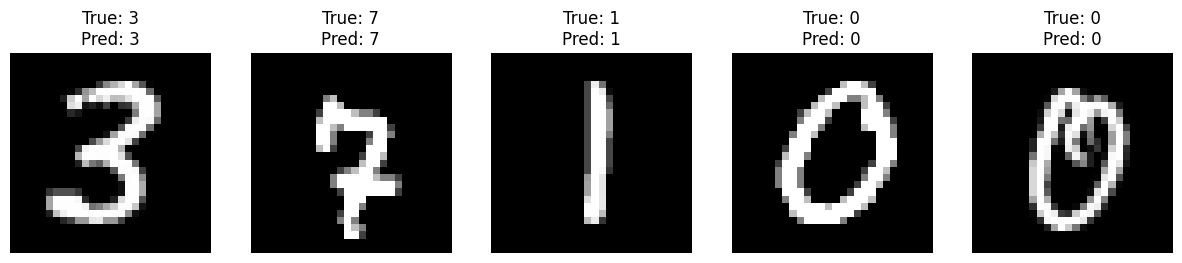

In [36]:
evaluate(blind_test_model, blind_test_dataset, batch_size=64)
predict_random_images(blind_test_model, blind_test_dataset)